<a href="https://colab.research.google.com/github/paulgureghian/Google_Colab_Notebooks/blob/master/Classifying_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Created by Paul A. Gureghian on 11/26/18.**

**This notebook uses the 'Fashion-MNIST' dataset and**

**PyTorch to classify clothing images.**

In [0]:
### Install CUDA driver
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

In [16]:
### Install PyTorch and Torchvision 
!pip3 install -U -q torchvision 
!pip3 install -U -q http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl

tcmalloc: large alloc 1073750016 bytes == 0x5936c000 @  0x7f97c002d2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
### Import packages
import torch
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import  datasets, transforms

In [0]:
### Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [0]:
### Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [0]:
### ### Download and load the testing data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [0]:
### Define a function to view an image and its predicted class
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [0]:
### Define a function to view the images
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

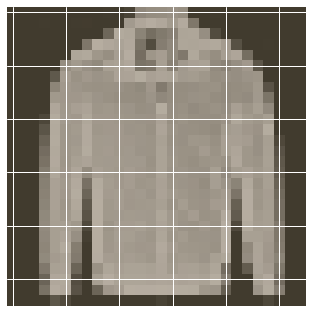

In [23]:
### View one of the images 
images, label = next(iter(trainloader))
imshow(images[0,:]);

**Build the network.**

**Here I will define the network with an input-layer with 784 inputs,**

**Two hidden-layers and an output-layer with 10 outputs.**

**I will use Relu activation functions for the layers.**



In [0]:
### Define the network architecture
class Classifier(nn.Module):
    def __init__(self):
      super().__init__()
      self.input_layer = nn.Linear(784, 256)
      self.hidden_layer1 = nn.Linear(256, 128)
      self.hidden_layer2 = nn.Linear(128, 64)
      self.output_layer = nn.Linear(64, 10)
      # Dropout module
      self.dropout = nn.Dropout(p=0.2)
      
    def forward(self, x):
      x = x.view(x.shape[0], -1)
      x = self.dropout(F.relu(self.input_layer(x)))
      x = self.dropout(F.relu(self.hidden_layer1(x)))
      x = self.dropout(F.relu(self.hidden_layer2(x)))
      x = F.log_softmax(self.output_layer(x), dim=1)
      
      return x    

**Train and validate the network.**



In [25]:
### Create the network, loss, and optimizer
model = Classifier()

### Define hyperparameters and metrics
steps = 0
epochs = 30
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr =0.005)
train_losses, test_losses = [], [] 

### Train the network 
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
    
        optimizer.zero_grad()
    
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item()

### Validate the network
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
      
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
      
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
  
        print("Epoch: {}/{}.. ".format(e+1, epochs),  
              "Training loss: {:.3f}.. ".format(train_losses[-1]),
              "Test_loss: {:.3f}.. ".format(test_losses[-1]),
              "Accuracy: {:.3f}.. ".format(accuracy/len(testloader)))   

Epoch: 1/30..  Training loss: 0.652..  Test_loss: 0.512..  Accuracy: 0.816.. 
Epoch: 2/30..  Training loss: 0.549..  Test_loss: 0.455..  Accuracy: 0.836.. 
Epoch: 3/30..  Training loss: 0.525..  Test_loss: 0.442..  Accuracy: 0.841.. 
Epoch: 4/30..  Training loss: 0.506..  Test_loss: 0.452..  Accuracy: 0.842.. 
Epoch: 5/30..  Training loss: 0.503..  Test_loss: 0.477..  Accuracy: 0.836.. 
Epoch: 6/30..  Training loss: 0.499..  Test_loss: 0.478..  Accuracy: 0.839.. 
Epoch: 7/30..  Training loss: 0.498..  Test_loss: 0.452..  Accuracy: 0.843.. 
Epoch: 8/30..  Training loss: 0.486..  Test_loss: 0.441..  Accuracy: 0.843.. 
Epoch: 9/30..  Training loss: 0.478..  Test_loss: 0.510..  Accuracy: 0.828.. 
Epoch: 10/30..  Training loss: 0.497..  Test_loss: 0.442..  Accuracy: 0.845.. 
Epoch: 11/30..  Training loss: 0.485..  Test_loss: 0.441..  Accuracy: 0.846.. 
Epoch: 12/30..  Training loss: 0.469..  Test_loss: 0.440..  Accuracy: 0.847.. 
Epoch: 13/30..  Training loss: 0.485..  Test_loss: 0.423..  A

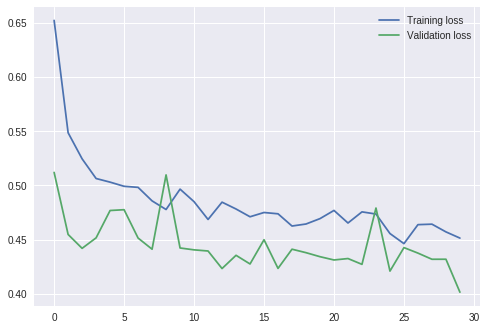

In [26]:
### Plot the losses
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False) 

Shape of the class probabilities:  torch.Size([1, 10])

tensor([[4.4102e-01, 1.0148e-03, 5.4317e-02, 2.1973e-02, 4.0040e-03, 8.7545e-05,
         4.7455e-01, 3.0596e-06, 3.0152e-03, 1.7367e-05]])



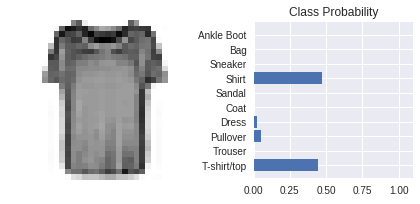

In [27]:
### View an image and its predicted class
model.eval()
dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
#img = images

### Convert 2D image to 1D vector
img = img.view(1, 784)

### Calculate class probabilities for the image
with torch.no_grad():
    output = model.forward(img)
ps = torch.exp(output) 
print("Shape of the class probabilities: ", ps.shape)
print('')
print(ps)
print('')

### Plot the image and its probabilities
view_classify(img.view(1, 28, 28), ps, version='Fashion') 

In [29]:
print(model.state_dict().keys())

odict_keys(['input_layer.weight', 'input_layer.bias', 'hidden_layer1.weight', 'hidden_layer1.bias', 'hidden_layer2.weight', 'hidden_layer2.bias', 'output_layer.weight', 'output_layer.bias'])
